In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/

!pip install torch==1.10.0

!pip install ujson

!pip install transformers

!pip install datasets

!pip install spacy

!pip install gitpython
!pip install jiwer
import torch

if torch.cuda.is_available():
    !pip install cupy-cuda111
  
import collections
from contextlib import nullcontext
from collections import namedtuple
from datasets import load_dataset
import json
import numpy as np
import random
import re 
import string
import torch
from datasets import load_dataset
from datasets import load_metric

from typing import List

seed = 1

np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from huggingface_hub import notebook_login



Mounted at /content/drive
/content/drive/My Drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████████▎ | 834.1 MB 1.3 MB/s eta 0:00:39tcmalloc: large alloc 1147494400 bytes == 0x6657a000 @  0x7f3a1a481615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████████████████████| 881.9 MB 18 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch

In [2]:
pathToData = "/content/drive/MyDrive/22 F/CS 35L/Eggheads/"

In [3]:
# convert annotations to dataframes to visualize classes
from pandas import DataFrame
from scipy.io import loadmat
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
import pathlib
dataset_url = "file:///content/drive/MyDrive/22 F/CS 35L/Eggheads/CarNoCar.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='carnocar',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

1892877983/1892877983 [==============================] - 35s 0us/step


In [5]:
data_dir

PosixPath('/root/.keras/datasets/carnocar')

In [6]:
image_count = len(list(data_dir.glob('not_car/*.JPEG')))
print(image_count)

16000


In [11]:
# clean dataset
import os
import imghdr

for file in data_dir.glob('*/*'):
    if imghdr.what(file) != 'jpeg':
        print(file)
        file.unlink()

Streaming output truncated to the last 5000 lines.
/root/.keras/datasets/carnocar/not_car/._n01667778_1129_n01667778.JPEG
/root/.keras/datasets/carnocar/not_car/._n01751748_3429_n01751748.JPEG
/root/.keras/datasets/carnocar/not_car/._n02119789_8957_n02119789.JPEG
/root/.keras/datasets/carnocar/not_car/._n02115641_17369_n02115641.JPEG
/root/.keras/datasets/carnocar/not_car/._n03000247_14166_n03000247.JPEG
/root/.keras/datasets/carnocar/not_car/._n04462240_11238_n04462240.JPEG
/root/.keras/datasets/carnocar/not_car/._n02107683_3908_n02107683.JPEG
/root/.keras/datasets/carnocar/not_car/._n02233338_17521_n02233338.JPEG
/root/.keras/datasets/carnocar/not_car/._n12057211_5890_n12057211.JPEG
/root/.keras/datasets/carnocar/not_car/._n02504458_6366_n02504458.JPEG
/root/.keras/datasets/carnocar/not_car/._n04141975_64459_n04141975.JPEG
/root/.keras/datasets/carnocar/not_car/._n01737021_14120_n01737021.JPEG
/root/.keras/datasets/carnocar/not_car/._n04550184_15718_n04550184.JPEG
/root/.keras/datase

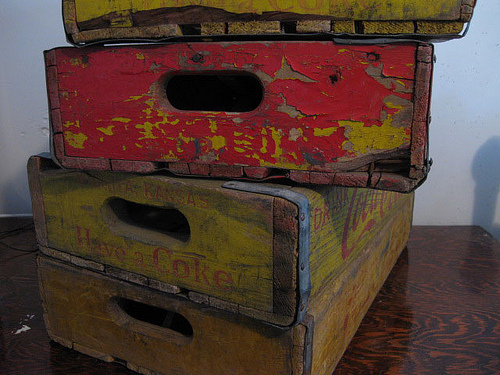

In [14]:
cars = list(data_dir.glob('car/*.jpg'))

no_cars = list(data_dir.glob('not_car/*.JPEG'))
PIL.Image.open(str(no_cars[0]))

In [15]:
batch_size = 32
img_height = 180
img_width = 180

In [16]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16041 files belonging to 2 classes.
Using 12833 files for training.


In [17]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16041 files belonging to 2 classes.
Using 3208 files for validation.


In [18]:
class_names = train_ds.class_names
print(class_names)

['car', 'not_car']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


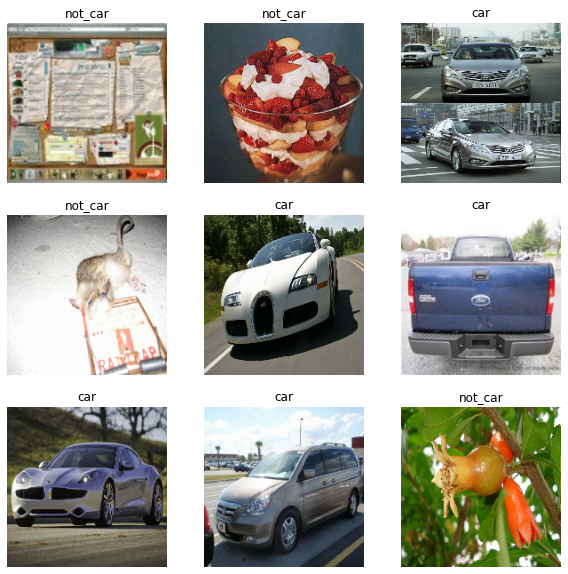

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(6):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [24]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [25]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [37]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [29]:
notebook_login()


In [44]:
history += model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=2
)# 10 seems best for now, val loss 0.1918, val acc 0.9804

Epoch 1/2
402/402 [==============================] - 544s 1s/step - loss: 0.0212 - accuracy: 0.9932 - val_loss: 0.2611 - val_accuracy: 0.9470
Epoch 2/2
402/402 [==============================] - 560s 1s/step - loss: 0.0166 - accuracy: 0.9954 - val_loss: 0.3732 - val_accuracy: 0.9342


TypeError: ignored

In [45]:
model._name = "carnocar"

In [46]:
model.summary()

Model: "carnocar"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 32)        924

In [47]:
model.save(pathToData + 'carnocar2.h5')

In [ ]:
import keras
from matplotlib import pyplot as plt


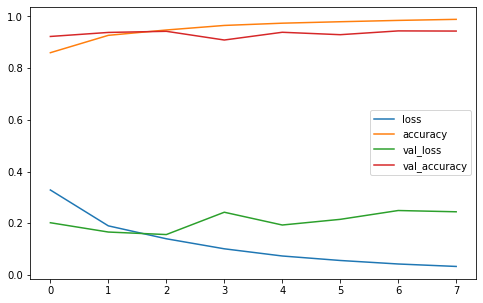

In [53]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [42]:
import pandas as pd

In [ ]:
hist_ds = pd.DataFrame(history.history)
with open("hist\.json", "w") as f:
  hist_ds.to_json(f)